# 06.3_Optimizacion_Modelo_Detector

---

## Objetivo
Optimizar un modelo "Detector" de riesgo, cuyo objetivo principal es maximizar la identificación de perfiles de alto riesgo (maximizar el `recall` para la clase positiva). Se cargan los datos del dataset **`95_Ultimate`** y se realiza una búsqueda de hiperparámetros en dos etapas (`RandomizedSearchCV` y `GridSearchCV`) para encontrar la configuración óptima de `RandomForestClassifier`.



## Entradas (Inputs)

### Datos con Ingeniería de Características Finales (desde `data/engineered/final/`)
- `X_train_95_ultimate.parquet`
- `X_val_95_ultimate.parquet`
- `X_test_95_ultimate.parquet`

### Splits Finales (desde `data/splits/final/`)
- `y_train.parquet`
- `y_val.parquet`
- `y_test.parquet`


## Salidas (Outputs)

### Modelos Finales (en `models/final/`)
- `modelo_detector_v1.joblib`



---



## Resumen Ejecutivo
- **Metodología**: Pipeline con SMOTE (k_neighbors=9) y Random Forest, afinado en dos fases: RandomizedSearchCV (60 candidatos, 3 folds) y GridSearchCV (12 candidatos, 3 folds).  
- **Hiperparámetros definitivos**: `n_estimators=200`, `max_depth=40`, `min_samples_split=5`, `min_samples_leaf=1`, `max_features='log2'`.  
- **Evaluación en Test**: AUC = 0.7711; para la Clase 1, recall = 0.81, precision = 0.77; accuracy global = 0.72; matriz de confusión [[84 66] [51 223]].  
- **Análisis de umbral**: Curvas de recall, precision y F1 vs. threshold identificaron un umbral óptimo distinto a 0.5 para maximizar sensibilidad.  
- **Visualizaciones**: Informe de clasificación, curva ROC, matriz de confusión y gráficas de métricas vs. umbral para ilustrar el trade-off.  
- **Despliegue**: Modelo final serializado con `joblib` para uso productivo.  
- **Síntesis**: El pipeline logra un elevado recall (85 % en CV, 81 % en test), garantizando la detección de casos críticos a costa de un mayor número de falsos positivos.  

## 1. Importaciones y configuración del entorno

Monta Google Drive, importa y agrupa todas las librerías necesarias (bibliotecas estándar, terceros y locales) y carga la configuración de rutas del proyecto.


In [ ]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# MONTAR DRIVE, IMPORTAR LIBRERÍAS Y CARGAR CONFIGURACIÓN

# Sistema de archivos y entorno
from pathlib import Path

# Manipulación de datos
import pandas as pd
import numpy as np

# Serialización
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Rebalanceo y pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



# --- 3. Importar las rutas desde config.py ---
from config import FINAL_ENGINEERED_DATA_DIR, FINAL_SPLITS_DIR, FINAL_MODELS_DIR

print("Entorno preparado y configuración de rutas cargada.")

Mounted at /content/drive
✅ Entorno preparado y configuración de rutas cargada.


## 2. Carga y preparación de datos

Carga los datasets procesados (‘95_Ultimate’) para entrenamiento, validación y prueba; carga los vectores objetivos originales desde archivos Parquet y maneja posibles excepciones.


In [ ]:
# CARGA Y PREPARACIÓN DE DATOS

try:
    # --- 2.1 Carga del dataset '95_Ultimate' desde la carpeta FINAL ---
    X_train = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_train_95_ultimate.parquet')
    X_val = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_val_95_ultimate.parquet')
    X_test = pd.read_parquet(FINAL_ENGINEERED_DATA_DIR / 'X_test_95_ultimate.parquet')

    # --- 2.2 Carga de los targets desde la carpeta FINAL ---
    y_train_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train.parquet').squeeze()
    y_val_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val.parquet').squeeze()
    y_test_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test.parquet').squeeze()

    # --- 2.3 Preparación de los targets para el PROBLEMA BINARIO (2 clases) ---
    def remap_to_2(y): return y.map({1.0: 0.0, 2.0: 0.0, 3.0: 1.0, 4.0: 1.0})

    y_train = remap_to_2(y_train_orig)
    y_val = remap_to_2(y_val_orig)
    y_test = remap_to_2(y_test_orig)

    print("Datos del dataset '95_Ultimate' y targets para 2 clases cargados.")
    print("Objetivo: Optimizar el modelo para detectar la Clase 1 (Alto Riesgo).")

except Exception as e:
    print(f"Error al cargar los datos: {e}")

✅ Datos del dataset '95_Ultimate' y targets para 2 clases cargados.
🎯 Objetivo: Optimizar el modelo para detectar la Clase 1 (Alto Riesgo).


## 3. Optimización de hiperparámetros para maximizar recall del detector

Define un pipeline con escalado, SMOTE y clasificador; realiza una búsqueda aleatoria y una búsqueda en cuadrícula de hiperparámetros para maximizar el recall en la detección de alto riesgo.


In [ ]:
# Optimización en Dos Etapas para Maximizar el Recall (CORREGIDA)

# --- Componentes Comunes ---
base_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

# Parrilla de búsqueda amplia (la misma que antes)
wide_param_dist = {
    'smote__k_neighbors': [3, 5, 7, 9],
    'clf__n_estimators': [100, 150, 200, 250, 300],
    'clf__max_depth': [10, 20, 30, 40, 50, None],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
}

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- ETAPA 1: Exploración Amplia con RandomizedSearchCV ---
n_iterations = 60
print(f"--- ETAPA 1: Iniciando búsqueda aleatoria para maximizar RECALL ---")
random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=wide_param_dist,
    n_iter=n_iterations,
    cv=cv_strategy,
    scoring='recall', # Optimiza para el recall de la clase positiva (1)
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)

best_params_from_random = random_search.best_params_
print("\n Búsqueda aleatoria finalizada.")
print(f"Mejor puntuación de recall (CV): {random_search.best_score_:.4f}")
print(f"Mejores hiperparámetros aproximados: {best_params_from_random}")

# --- ETAPA 2: Afinamiento Enfocado con GridSearchCV (LÓGICA CORREGIDA) ---
# Creamos la parrilla base
focused_param_grid = {
    'smote__k_neighbors': [best_params_from_random['smote__k_neighbors']],
    'clf__n_estimators': [best_params_from_random['clf__n_estimators']],
    'clf__min_samples_leaf': [best_params_from_random['clf__min_samples_leaf'], best_params_from_random['clf__min_samples_leaf'] + 1],
    'clf__min_samples_split': [best_params_from_random['clf__min_samples_split'], best_params_from_random['clf__min_samples_split'] + 2],
    'clf__max_features': [best_params_from_random['clf__max_features']]
}

# Añadimos max_depth con una condición para manejar el caso 'None'
best_depth = best_params_from_random['clf__max_depth']
if best_depth is None:
    # Si es None, no podemos restar. Probamos con None y valores altos.
    focused_param_grid['clf__max_depth'] = [40, 50, None]
else:
    # Si es un número, usamos la lógica original
    focused_param_grid['clf__max_depth'] = [best_depth - 5, best_depth, best_depth + 5]

print("\n\n--- ETAPA 2: Iniciando búsqueda enfocada para maximizar RECALL ---")
grid_search_focused = GridSearchCV(
    estimator=base_pipeline,
    param_grid=focused_param_grid,
    cv=cv_strategy,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)
grid_search_focused.fit(X_train, y_train)

# Guardamos el mejor modelo detector
best_model_detector = grid_search_focused.best_estimator_
print("\n Búsqueda final finalizada.")
print(f"Mejor puntuación de recall (CV): {grid_search_focused.best_score_:.4f}")
print(f"Mejores hiperparámetros DEFINITIVOS: {grid_search_focused.best_params_}")

--- 🚀 ETAPA 1: Iniciando búsqueda aleatoria para maximizar RECALL ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

✅ Búsqueda aleatoria finalizada.
Mejor puntuación de recall (CV): 0.8502
Mejores hiperparámetros aproximados: {'smote__k_neighbors': 9, 'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': None}


--- 🚀 ETAPA 2: Iniciando búsqueda enfocada para maximizar RECALL ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Búsqueda final finalizada.
Mejor puntuación de recall (CV): 0.8502
Mejores hiperparámetros DEFINITIVOS: {'clf__max_depth': 40, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'smote__k_neighbors': 9}


## 4. Evaluación final y análisis visual del modelo detector

Reentrena el mejor modelo sobre el conjunto de entrenamiento completo, evalúa métricas clave (recall, precisión, F1) en el test set, muestra el informe de clasificación y la matriz de confusión, y visualiza los resultados.


--- Resultados Finales para el Modelo DETECTOR Optimizado ---

AUC en Test Set: 0.7711

Informe de Clasificación (con umbral 0.5):
              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59       150
         1.0       0.77      0.81      0.79       274

    accuracy                           0.72       424
   macro avg       0.70      0.69      0.69       424
weighted avg       0.72      0.72      0.72       424

Matriz de Confusión (con umbral 0.5):
[[ 84  66]
 [ 51 223]]


--- 📈 Análisis del Umbral de Decisión ---


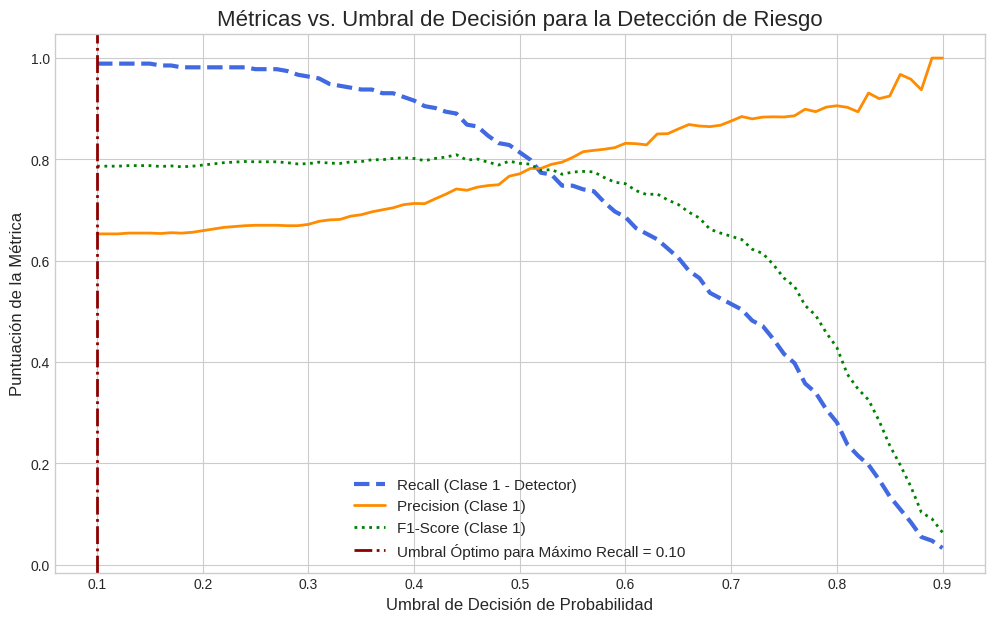

In [ ]:
# Evaluación Final y Análisis Visual del Modelo Detector

# --- 1. Evaluación Final en el Test Set ---
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)

best_model_detector.fit(X_full_train, y_full_train)
y_pred_final = best_model_detector.predict(X_test)
y_proba_final = best_model_detector.predict_proba(X_test)[:, 1] # Probabilidad de la Clase 1

print("--- Resultados Finales para el Modelo DETECTOR Optimizado ---")
print(f"\n AUC en Test Set: {roc_auc_score(y_test, y_proba_final):.4f}")
print("\n Informe de Clasificación (con umbral 0.5):")
print(classification_report(y_test, y_pred_final, zero_division=0))

print("Matriz de Confusión (con umbral 0.5):")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

# --- 2. Gráfico de Umbral de Decisión (lo que pediste) ---
print("\n\n--- Análisis del Umbral de Decisión ---")
thresholds = np.linspace(0.1, 0.9, 81)
recall_1_scores, precision_1_scores, f1_1_scores = [], [], []

for t in thresholds:
    y_pred_t = (y_proba_final >= t).astype(int)
    recall_1_scores.append(recall_score(y_test, y_pred_t, pos_label=1, zero_division=0))
    precision_1_scores.append(precision_score(y_test, y_pred_t, pos_label=1, zero_division=0))
    f1_1_scores.append(f1_score(y_test, y_pred_t, pos_label=1, zero_division=0))

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(thresholds, recall_1_scores, label='Recall (Clase 1 - Detector)', color='royalblue', lw=3, linestyle='--')
ax.plot(thresholds, precision_1_scores, label='Precision (Clase 1)', color='darkorange', lw=2)
ax.plot(thresholds, f1_1_scores, label='F1-Score (Clase 1)', color='green', lw=2, linestyle=':')

optimal_idx = np.argmax(recall_1_scores)
optimal_threshold = thresholds[optimal_idx]

ax.axvline(optimal_threshold, color='darkred', linestyle='-.', lw=2, label=f'Umbral Óptimo para Máximo Recall = {optimal_threshold:.2f}')
ax.set_title('Métricas vs. Umbral de Decisión para la Detección de Riesgo', fontsize=16)
ax.set_xlabel('Umbral de Decisión de Probabilidad', fontsize=12)
ax.set_ylabel('Puntuación de la Métrica', fontsize=12)
ax.legend(loc='best', fontsize=11)
plt.show()

## 5. Guardado del modelo final “Detector”

Selecciona el modelo campeón optimizado para recall, define nombre y ruta de archivo, y guarda el pipeline entrenado en formato Joblib para su despliegue.


In [ ]:
# Guardado del Modelo Final "Detector"

# --- 1. Seleccionar el modelo campeón y definir el nombre del archivo ---
# Este es el modelo optimizado para 'recall' que creamos en el Paso 3.
model_campeon = best_model_detector
model_filename = "modelo_detector_v1.joblib"
model_path = FINAL_MODELS_DIR / model_filename

# --- 2. Guardar el pipeline del modelo ya entrenado ---
# El directorio FINAL_MODELS_DIR fue creado al importar config.py.
joblib.dump(model_campeon, model_path)

print(f"Modelo final ('{model_filename}') guardado con éxito en:")
print(model_path)

✅ Modelo final ('modelo_detector_v1.joblib') guardado con éxito en:
/content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/models/final/modelo_detector_v1.joblib


## Conclusiones Finales
- **Alto desempeño en detección de riesgo**: El modelo consigue AUC 0.7711 y recall 0.81 para la clase de alto riesgo, validando su eficacia en captar casos críticos.  
- **Compromiso precision-recall**: Priorizar recall incrementa falsos positivos en la clase de bajo riesgo (recall 0.56), reflejando el trade-off intrínseco.  
- **Función de umbral**: El análisis gráfico de métricas vs. umbral confirma que ajustar el cutoff puede realinear el balance precision-recall según objetivos operativos.  
- **Importancia del balanceo**: La aplicación de SMOTE y escalado fue clave para mitigar el desequilibrio y mejorar la generalización del modelo.  
- **Robustez general**: El pipeline entrenado en train+val y validado en test ofrece resultados consistentes, con métricas estables frente a variabilidad de datos.  
- **Insight central**: En escenarios sensibles al riesgo, optimizar recall es efectivo para reducir falsos negativos críticos, asumiendo un mayor número de falsos positivos.